In [1]:
import cv2
import numpy as np, matplotlib.pyplot as plt
from cvflow import *
import laneFindingPipeline, utils
%matplotlib inline

In [2]:
getattr(Constant('zeros'), 'theConstant', None) == 'zeros'

True

In [3]:
from utils import show

In [4]:
allFrames = laneFindingPipeline.utils.loadFrames(maxframes=100)

HBox(children=(IntProgress(value=0, description='load project: '), HTML(value='')))

HBox(children=(IntProgress(value=0, description='load challenge: '), HTML(value='')))

HBox(children=(IntProgress(value=0, description='load harder_challenge: '), HTML(value='')))

In [5]:
class HSVshow(Pipeline):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        undistort = Undistort(self.input)
        perspective = Perspective(undistort)
        hsv = CvtColor(perspective, cv2.COLOR_RGB2HSV)
        s, v = [ColorSplit(hsv, k) for k in range(1, 3)]
#         s_binary = CountSeekingThreshold(s, goalCount=11000)
#         v_binary = CountSeekingThreshold(v, goalCount=11000)
        s_sharp = UnsharpMask(Blur(s))
        s_binary = SobelClip(
            s_sharp, narrowIterations=5, wideIterations=16, dilationIterations=8,
            thresholdKwargs=dict(
                goalCount=13000,
            )
        )
        s_binary.nodeName = 'SobelClip(Unsharp))'
        
        # Do some DilateSobels directly on HS[V].
        self.vdilateSobel = DilateSobel(v, dilationIterations=10, sx_thresh=30)
        self.vdilateSobelInv = DilateSobel(self.vdilateSobel, dilationIterations=10, sx_thresh=30)
        trenchesNridges = self.vdilateSobel | self.vdilateSobelInv
        trenchesNridges.nodeName = 'trenches and ridges'
        
        resobel = DilateSobel(trenchesNridges, preblurksize=65)
        #resobel = Blur(trenchesNridges, ksize=65)
        resobel.nodeName = 'resobel'
        self.includeInMultistep([resobel])
        
        whiteTarget = resobel & trenchesNrid ges
        whiteTarget.nodeName = 'targeting white lines'
        self.includeInMultistep([whiteTarget])
        
        # Do a SobelClip on HS[V].
        v_binary = SobelClip(
            v, narrowIterations=10, wideIterations=20, dilationIterations=8,
            thresholdKwargs=dict(
                goalCount=19000,
            )
        )
        v_binary.nodeName = 'SobelClip(HS[V])'
        
        self.output = s_binary & trenchesNridges | whiteTarget | v_binary
        self.constructColorOutpout(self.vdilateSobel, self.vdilateSobelInv, s_binary)
        
        self.includeInMultistep([
            undistort, perspective, hsv, s, v, #h,
            self.vdilateSobel, self.vdilateSobelInv,
            s_sharp,
            s_binary, v_binary,
            self.output.nparent(1),
            self.output.nparent(2),
            self.output.nparent(3),
            self.output.nparent(4),
        ])

HBox(children=(IntProgress(value=0, description='cal. undistort: ', max=20), HTML(value='')))

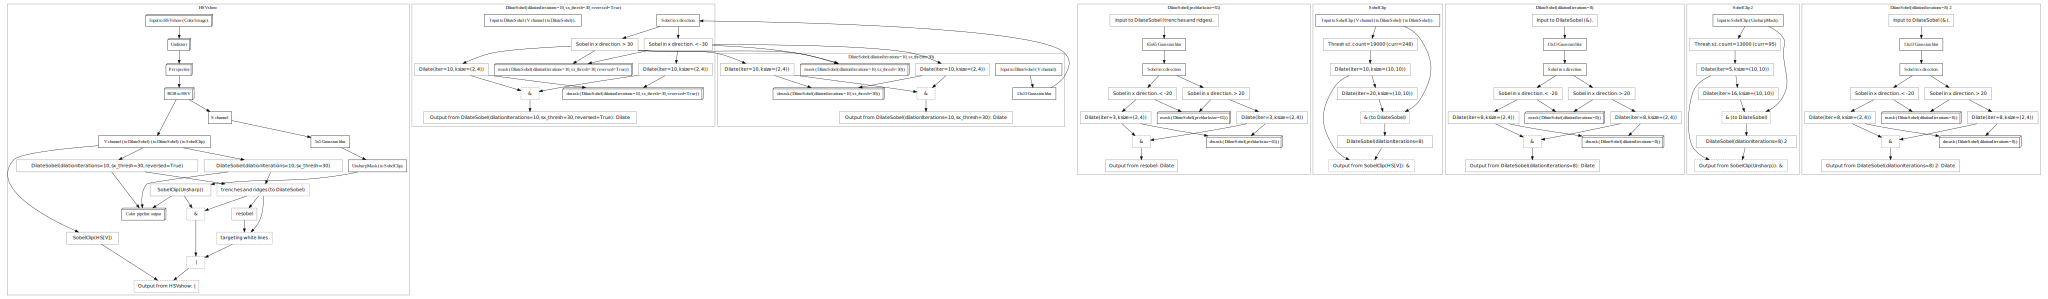

In [6]:
frame = allFrames['harder_challenge'][-12]
hsvshow = HSVshow()
hsvshow(frame)
hsvshow.assembleGraph()
hsvshow.draw(addKey=False, linkMultisteps=)

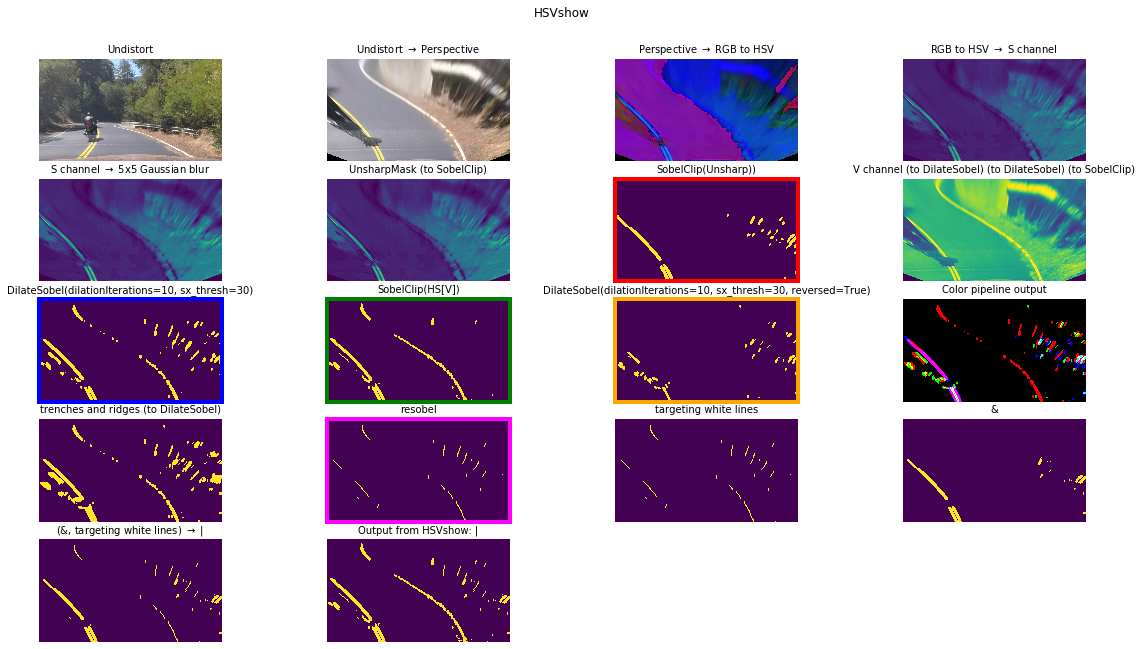

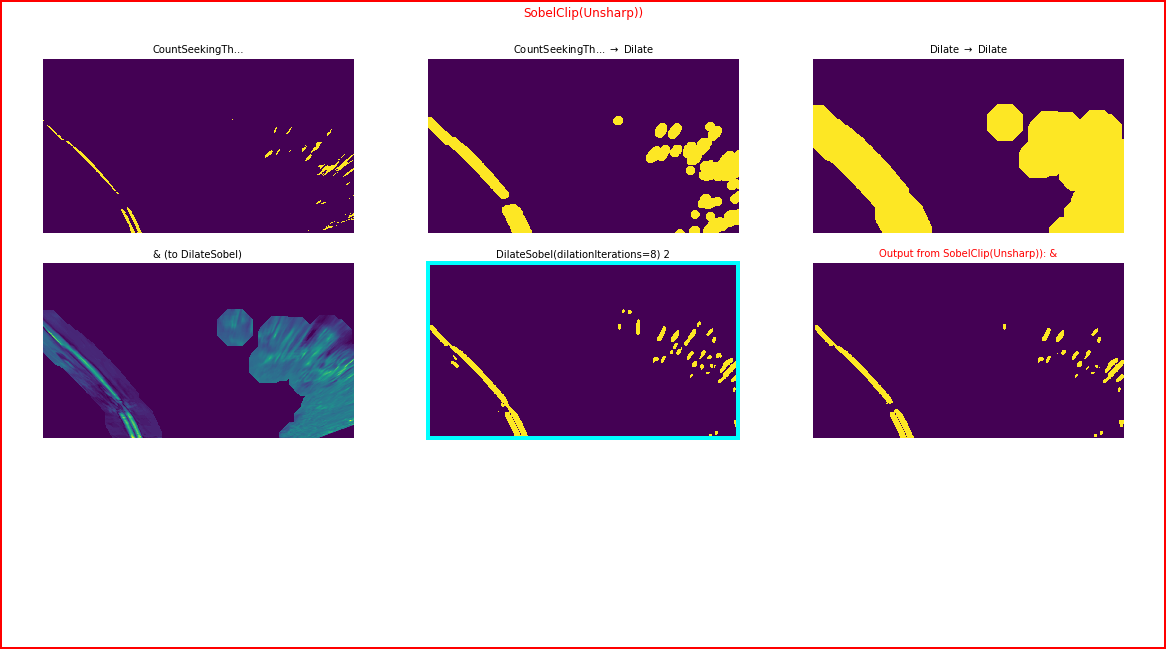

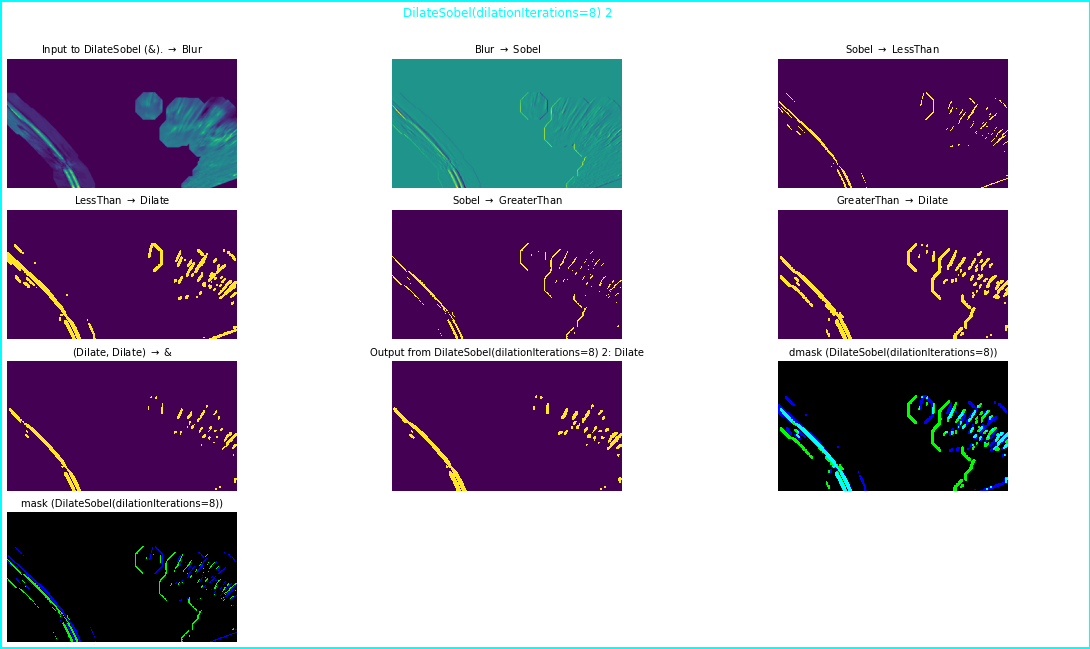

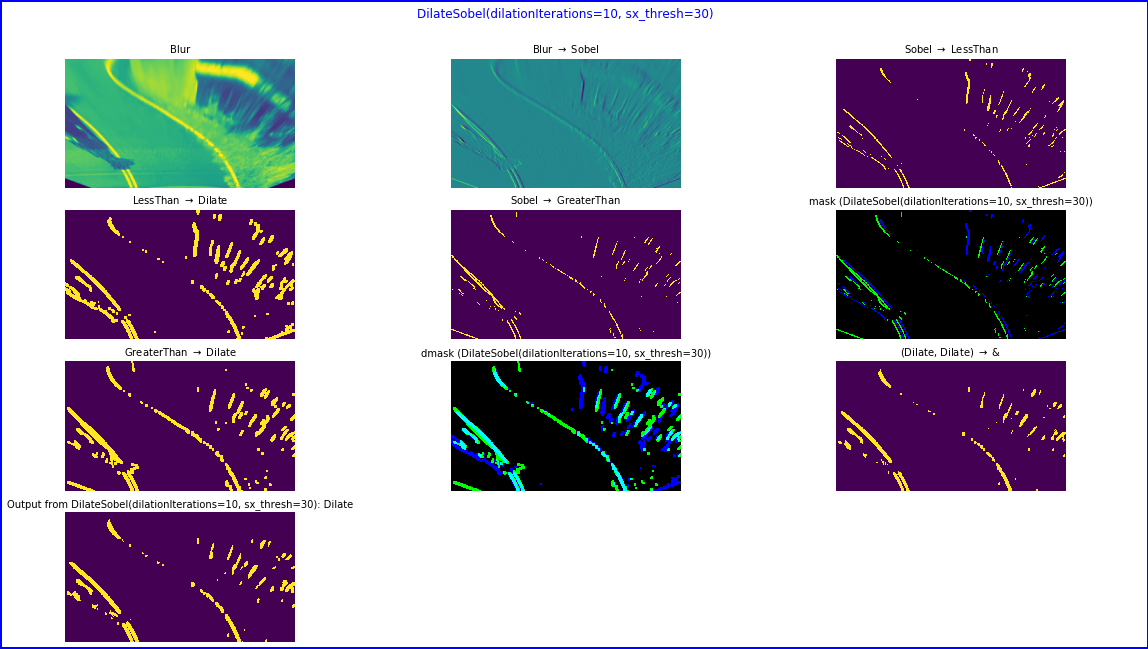

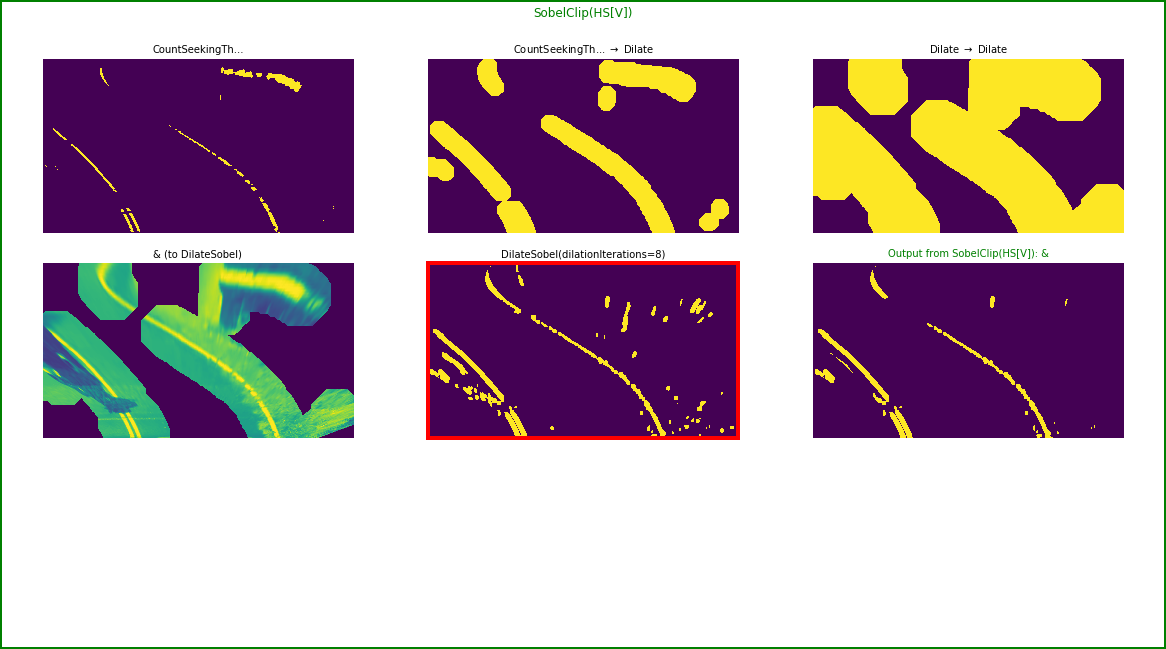

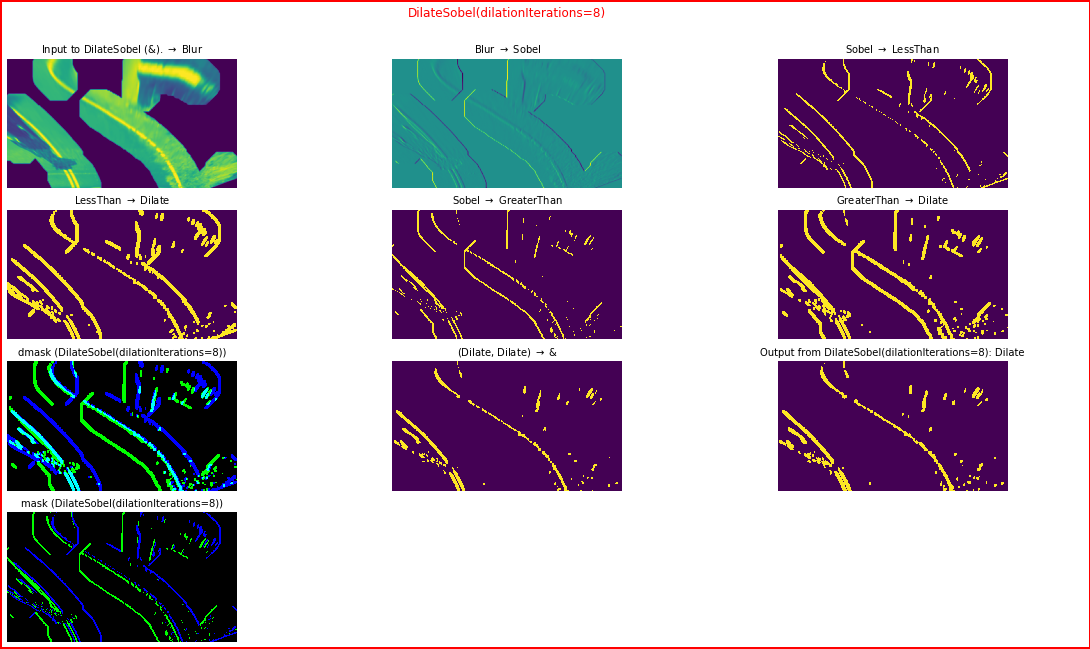

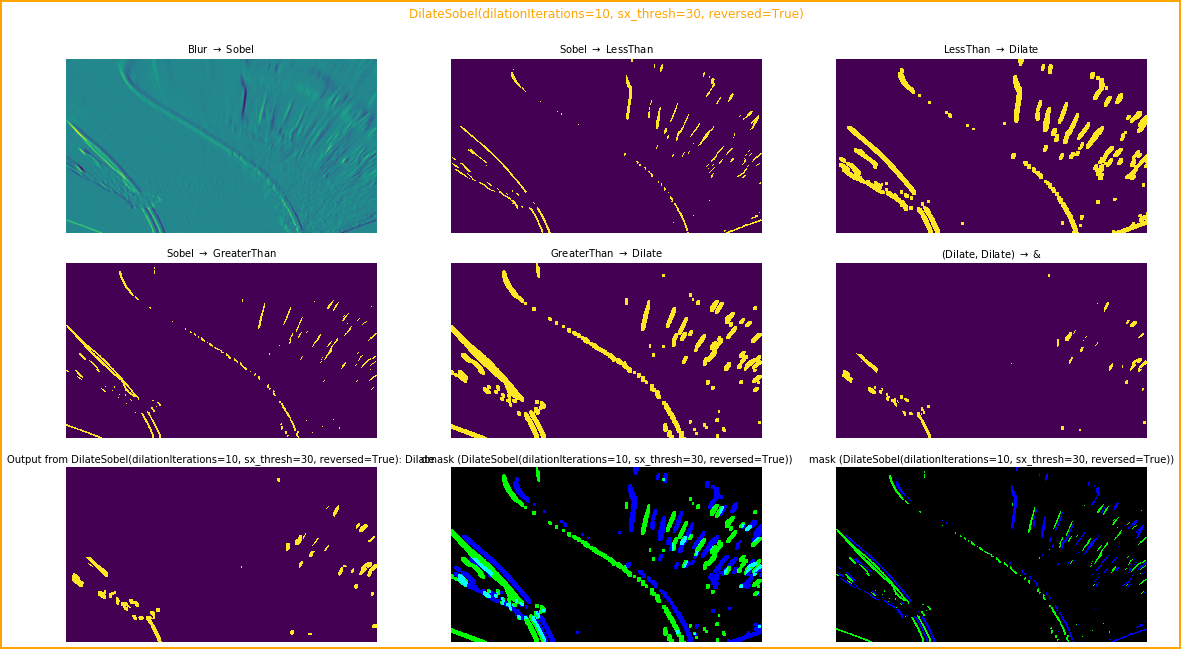

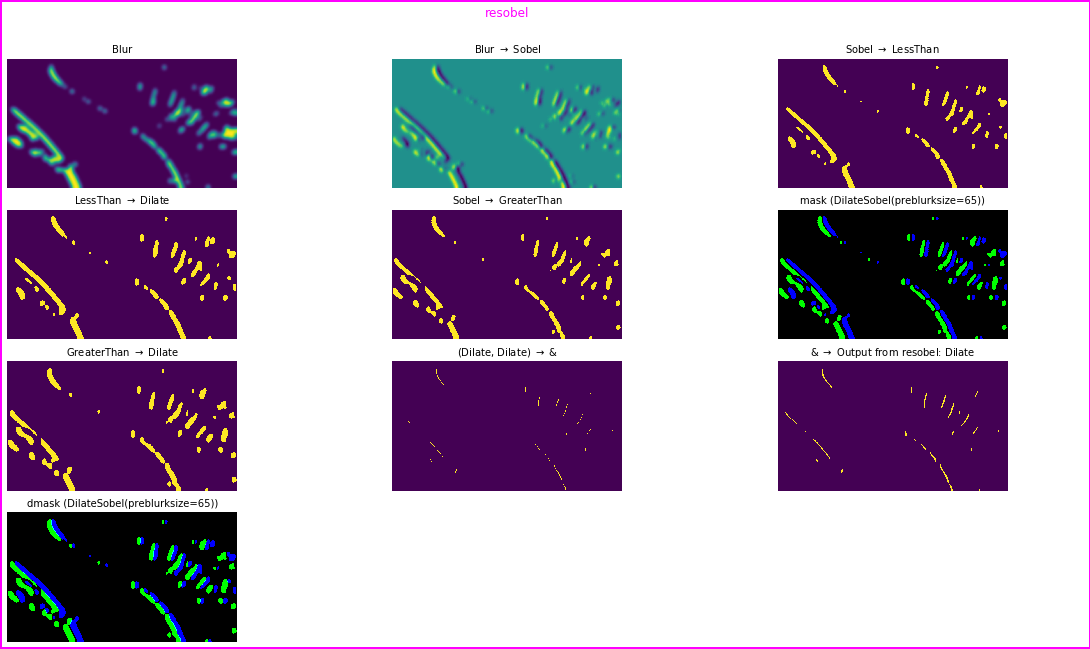

In [7]:
hsvshow.showMembers(
    subplotKwargs=dict(figsize=(16,9)), 
    wspace=0, showMultistepParents=True
)